In [2]:
from omegaconf import DictConfig, OmegaConf
from hydra import initialize, compose
with initialize(config_path="../conf", version_base="1.3"):
    cfg = compose(config_name="config_data_creation_microfluidic_device")
    print(OmegaConf.to_yaml(cfg))

paths:
  root_abs: /home/alex/dev/python/tx_rbc/tx_shared/
  data_from_notebooks: ../data/
  constructed_dataset: data/constructed_datasets/copy_paste_microfluidic
  constructed_dataset_test: data/constructed_datasets/copy_paste_microfluidic_test
  liang_2024_from_root: data/2024_liang
  kihm_2018_from_root: data/2018_plos
  nouaman_from_root: data/2024_nouaman
  nouaman_videos_from_root: data/videos/nouaman_2024
  naples_tif_stack: data/tomaiuolo_naples
dataset_distribution:
  train_liang: 10
  train_nouaman: 80
  train_kihm: 70
  test_liang: 90
  test_nouaman: 10
  test_kihm: 15
  val_liang: 0
  val_nouaman: 10
  val_kihm: 15
factors:
  noise_fn:
  - none
  - gaussian
  - salt_pepper
  - random
  croissant_count:
  - 1
  - 2
  slipper_count:
  - 1
  - 2
  object_count:
  - 1
  - 2
  lines:
  - true
  - false
  artifacts:
  - true
  - false
  channel_state:
  - lighten_channel
  - darken_channel
  - normal
parameters:
  inner_line_space:
  - 40
  - 75
  image_height: 200
  image_width

# Cell segmentation

In [42]:
def estimate_background(frames, diff_thresh=30, min_similar_frames_percent=.6):
    """
    Estimate background by finding slices that are similar to many other slices
    
    Args:
        frames: Array of frames from TIFF stack
        diff_thresh: Threshold for considering frames different
        min_similar_frames_percent: Minimum ratio of similar frames needed to consider as background. `0.6` for "at least 60%".
    
    Returns:
        Background frame (numpy array)
    """
    n_frames = len(frames)
    
    # Convert all frames to grayscale for comparison
    gray_frames = []
    for frame in frames:
        if len(frame.shape) == 3:
            gray_frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY))
        else:
            gray_frames.append(frame)
    
    gray_frames = np.array(gray_frames)
    
    # For each frame, count how many other frames are similar to it
    similarity_counts = []
    
    for i in range(n_frames):
        similar_count = 0
        current_frame = gray_frames[i]
        
        for j in range(n_frames):
            if i != j:
                other_frame = gray_frames[j]
                
                
                diff = cv2.absdiff(current_frame, other_frame) # Compute difference
                diff_pixels = np.sum(diff > diff_thresh)       # Count pixels with significant difference
                total_pixels = diff.shape[0] * diff.shape[1]   # If few pixels are different, frames are similar
                diff_ratio = diff_pixels / total_pixels
                
                # Consider frames similar if less than 5% of pixels are significantly different
                if diff_ratio < 0.01:
                    similar_count += 1
        
        similarity_counts.append(similar_count)
    
    # Find the frame with the highest similarity count
    best_bg_idx = np.argmax(similarity_counts)
    max_similar = similarity_counts[best_bg_idx]
    
    print(f"Best background frame {best_bg_idx} has {max_similar} similar frames")
    
    # Check if we found a good background (enough similar frames)
    if max_similar/n_frames < min_similar_frames_percent:
        print(f"Warning: Best background only has {max_similar} similar frames (minimum {min_similar_frames_percent})")
        print("Falling back to median background")
        return np.median(frames, axis=0).astype(np.uint8)
    
    # Return the original color frame (not grayscale)
    return frames[best_bg_idx].astype(np.uint8)

In [217]:
import cv2
import numpy as np
from PIL import Image
import os
import glob
from pathlib import Path

def preprocess_mask(mask, kernel_size=3, close_iterations=2, open_iterations=1):
    """Clean up binary mask with morphological operations"""
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (kernel_size, kernel_size))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel, iterations=close_iterations) # Close small gaps
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel, iterations=open_iterations)   # Remove small noise
    return mask

def load_tif_stack(filepath):
    """Load TIF stack and return as numpy array"""
    with Image.open(filepath) as img:
        frames = []
        try:
            while True:
                # Convert to numpy array and ensure it's uint8
                frame = np.array(img)
                if len(frame.shape) == 2:  # Grayscale
                    frame = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
                elif len(frame.shape) == 3 and frame.shape[2] == 4:  # RGBA
                    frame = cv2.cvtColor(frame, cv2.COLOR_RGBA2BGR)
                
                frames.append(frame)
                img.seek(img.tell() + 1)
        except EOFError:
            pass  # End of stack
    
    return np.array(frames)

def find_different_frames(frames, background, diff_thresh=30, min_diff_pixels=100):
    """Find frames that are significantly different from background"""
    different_frames = []
    
    for i, frame in enumerate(frames):
        # Convert to grayscale
        gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        gray_bg = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
        
        # Compute difference
        diff = cv2.absdiff(gray_frame, gray_bg)
        
        # Count pixels above threshold
        diff_pixels = np.sum(diff > diff_thresh)
        
        if diff_pixels > min_diff_pixels:
            different_frames.append(i)
    
    return different_frames

def extract_cell_bbox(frame, background, PADDING, diff_thresh=30, morph_kernel_size=3, 
                     close_iterations=2, open_iterations=1, min_contour_area=50):
    """Extract cell bounding box from frame using background subtraction"""
    
    # Convert to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_bg = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
    
    # Compute absolute difference
    diff = cv2.absdiff(gray_frame, gray_bg)
    
    # Apply threshold to create binary mask
    _, mask = cv2.threshold(diff, diff_thresh, 255, cv2.THRESH_BINARY)
    
    # Clean up the mask with morphological operations
    mask = preprocess_mask(mask, morph_kernel_size, close_iterations, open_iterations)
    
    # Find contours
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:
        return None, None
    
    # Filter contours by area and find the largest one (likely the cell)
    valid_contours = [cnt for cnt in contours if cv2.contourArea(cnt) > min_contour_area]
    
    if not valid_contours:
        return None, None
    
    # Get the largest contour (most likely the cell)
    largest_contour = max(valid_contours, key=cv2.contourArea)
    
    # Get bounding box
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Add some padding
    padding = PADDING
    x = max(0, x - padding)
    y = max(0, y - padding)
    w = min(frame.shape[1] - x, w + 2*padding)
    h = min(frame.shape[0] - y, h + 2*padding)
    
    # Extract cell region

    frame_black_white = frame#np.where(frame-background > 0.99, frame, 0)
    cell_region = frame_black_white[y:y+h, x:x+w]
    
    return cell_region, (x, y, w, h)

def check_object_fully_entered(frame, background, bbox, edge_buffer_cols, diff_thresh):
    """Check if object is fully entered by verifying edge columns are background-like"""
    x0, y0, w, h = bbox
    x1, y1 = x0+w, y0+h
    h, w = frame.shape[:2]
    
    # Convert to grayscale
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray_bg = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
    
    # Check left edge buffer
    left_buffer_start = max(0, x0 - edge_buffer_cols)
    left_buffer_end = x0
    if left_buffer_end > left_buffer_start:
        left_region_frame = gray_frame[y0:y1, left_buffer_start:left_buffer_end]
        left_region_bg = gray_bg[y0:y1, left_buffer_start:left_buffer_end]
        left_diff = cv2.absdiff(left_region_frame, left_region_bg)
        left_mean_diff = np.mean(left_diff)
        if left_mean_diff > diff_thresh * 0.5:  # Half threshold for edge checking
            return -1
    
    # Check right edge buffer  
    right_buffer_start = x1
    right_buffer_end = min(w, x1 + edge_buffer_cols)
    if right_buffer_end > right_buffer_start:
        right_region_frame = gray_frame[y0:y1, right_buffer_start:right_buffer_end]
        right_region_bg = gray_bg[y0:y1, right_buffer_start:right_buffer_end]
        right_diff = cv2.absdiff(right_region_frame, right_region_bg)
        right_mean_diff = np.mean(right_diff)
        if right_mean_diff > diff_thresh * 0.5:  # Half threshold for edge checking
            return 1
    
    # Check if object is too close to frame edges
    if x0 < edge_buffer_cols:
        return -2
    if x1 > (w - edge_buffer_cols):
        return -2
    
    return 0

def process_tiff_file(folder, filepath, output_dir, output_dir_images, PADDING, edge_buffer_cols, diff_thresh=30, min_diff_pixels=100):
    """Process single TIFF file and extract cells"""
    
    print(f"Processing {filepath}...")
    
    # Load TIF stack
    frames = load_tif_stack(filepath)
    
    if len(frames) == 0:
        print(f"No frames found in {filepath}")
        return
    
    print(f"Loaded {len(frames)} frames")
    
    # Estimate background
    background = estimate_background(frames)
    #Image.fromarray(background).save(os.path.join(output_dir,  f"{folder}_"+Path(filepath).stem + "_bg.png"))
    
    # Find frames with cells
    different_frame_indices = find_different_frames(frames, background, diff_thresh, min_diff_pixels)
    
    print(f"Found {len(different_frame_indices)} frames with potential cells")
    
    # Extract cells from different frames
    file_stem = Path(filepath).stem
    cells_extracted = 0
    bboxes = []
    filenames= []
    for frame_idx in different_frame_indices:
        frame = frames[frame_idx]
        
        # Extract cell
        cell_region, bbox = extract_cell_bbox(frame, background, PADDING, diff_thresh)

        if bbox is None or cell_region is None:
            continue
        
        if bbox[2] < MIN_WIDTH or  bbox[3] < MIN_HEIGHT:
            continue # Cell to small => likely not a cell

        """
        plt.figure()
        fmb = frame-background
        plt.imshow()
        plt.show()
        if frame_idx > 10:
            return
        continue
        """        
        
        if check_object_fully_entered(frame, background, bbox, edge_buffer_cols, diff_thresh) == 0:
            # Save cell image
            output_filename = f"{folder}_{file_stem}_cell_{frame_idx:03d}.png"
            output_path = os.path.join(output_dir, output_filename)
            
            # Convert BGR to RGB for saving
            cell_rgb = cv2.cvtColor(cell_region, cv2.COLOR_BGR2RGB)
            Image.fromarray(cell_rgb).save(output_path)

            output_path = os.path.join(output_dir_images, output_filename)
            cell_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            Image.fromarray(cell_rgb).save(output_path)
            
            cells_extracted += 1
            bboxes.append(bbox)
            filenames.append(output_filename)
            print(f"  Extracted cell from frame {frame_idx} -> {output_filename}")

    print(f"Extracted {cells_extracted} cells from {filepath}")
    return bboxes, filenames

Found 79 TIFF files to process
Processing /home/alex/dev/python/tx_rbc/tx_shared/data/tomaiuolo_naples/v 0.12 cm:s/glob001.tif...
Loaded 16 frames
Best background frame 0 has 12 similar frames
Found 7 frames with potential cells
  Extracted cell from frame 5 -> v 0.12 cm:s_glob001_cell_005.png
  Extracted cell from frame 6 -> v 0.12 cm:s_glob001_cell_006.png
  Extracted cell from frame 7 -> v 0.12 cm:s_glob001_cell_007.png
  Extracted cell from frame 8 -> v 0.12 cm:s_glob001_cell_008.png
Extracted 4 cells from /home/alex/dev/python/tx_rbc/tx_shared/data/tomaiuolo_naples/v 0.12 cm:s/glob001.tif
Processing /home/alex/dev/python/tx_rbc/tx_shared/data/tomaiuolo_naples/v 0.12 cm:s/glob002.tif...
Loaded 15 frames
Best background frame 2 has 11 similar frames
Found 5 frames with potential cells
  Extracted cell from frame 0 -> v 0.12 cm:s_glob002_cell_000.png
  Extracted cell from frame 1 -> v 0.12 cm:s_glob002_cell_001.png
Extracted 2 cells from /home/alex/dev/python/tx_rbc/tx_shared/data/to

ValueError: zero-size array to reduction operation fmin which has no identity

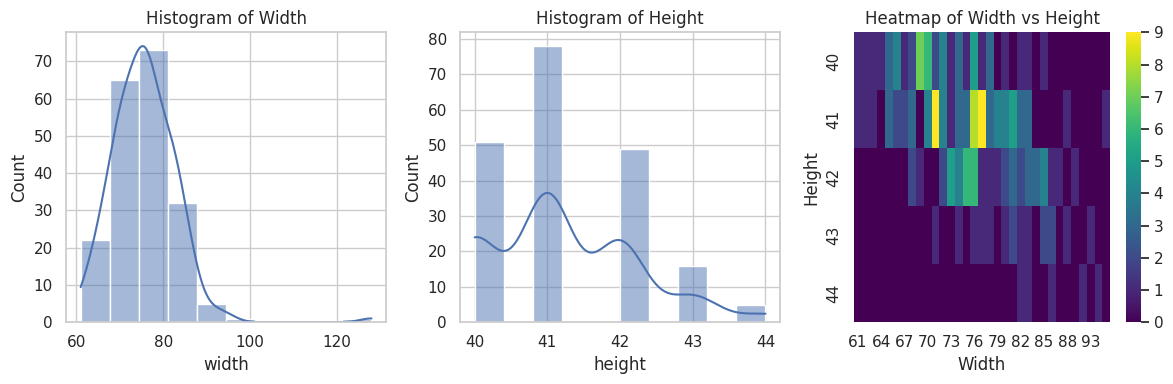

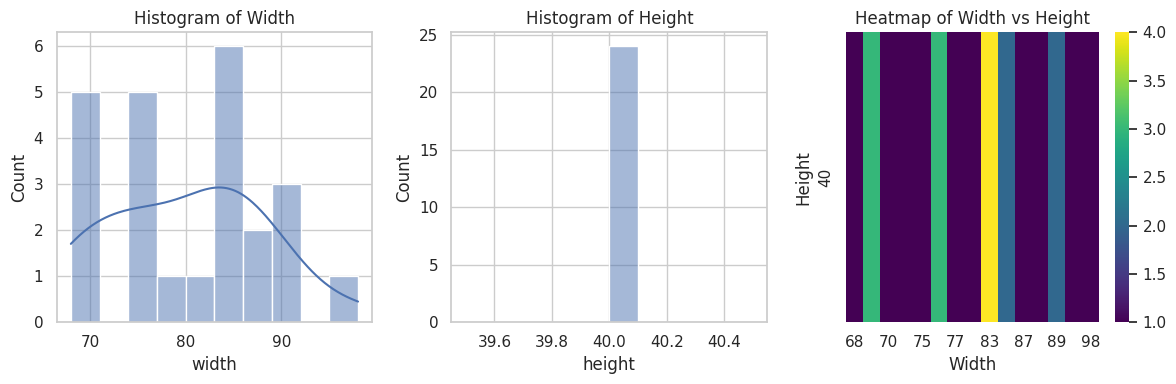

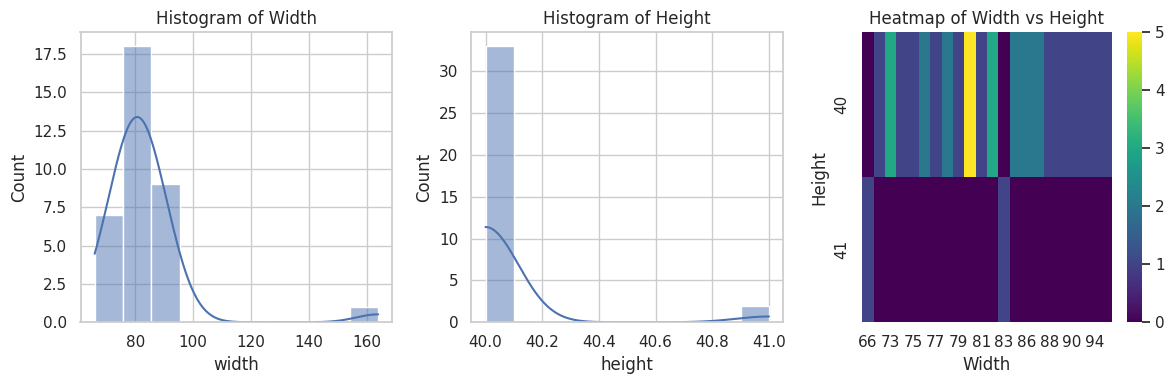

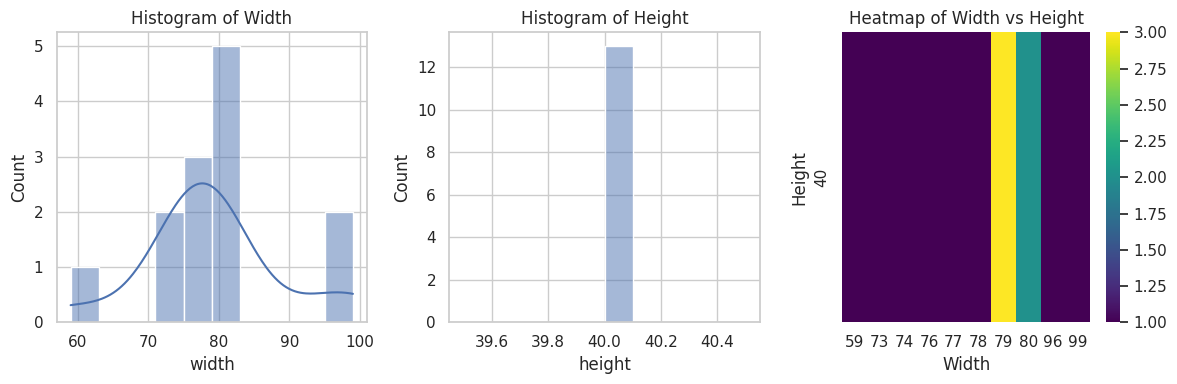

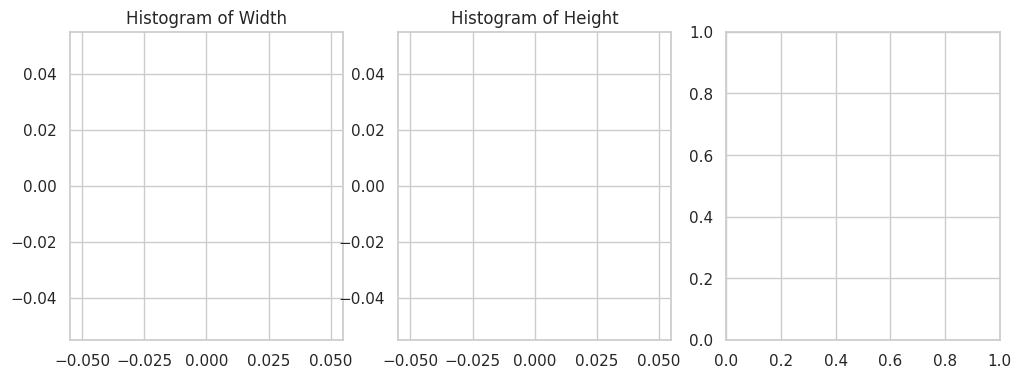

In [222]:
# Configuration
input_dir = os.path.join(cfg.paths.root_abs, cfg.paths.naples_tif_stack)
output_dir = os.path.join(cfg.paths.root_abs, cfg.paths.naples_tif_stack, "segmented_no_pad")
os.makedirs(output_dir, exist_ok=True)
output_dir_images = os.path.join(output_dir, "images")
output_dir_images_extracted = os.path.join(output_dir, "cells")
output_dir_labels = os.path.join(output_dir, "labels")
os.makedirs(output_dir_images, exist_ok=True)
os.makedirs(output_dir_labels, exist_ok=True)
os.makedirs(output_dir_images_extracted, exist_ok=True)

# Processing parameters
DIFF_THRESH = 20          # Threshold for pixel difference
DIFF_THRESH_folder_1cm=10
MIN_DIFF_PIXELS = 200     # Minimum number of different pixels to consider frame as having cell
PADDING = 0               # Padding around extracted cell
EDGE_BUFFER_COLS = 10     # Minimum columns of background needed at left/right edges for the cell to be considered "fully entered"
MIN_HEIGHT, MIN_WIDTH = 40, -1

# Process each folder, each file
for folder in [f for f in sorted(os.listdir(input_dir)) if os.path.isdir(os.path.join(input_dir, f))]:

    if "v 1 cm:s" in folder:
        diff = DIFF_THRESH_folder_1cm
    else:
        diff = DIFF_THRESH
    bboxes = []
    
    if folder in ["segmented_wb", "extracted", "extracted_cellpose", "segmented", "segmented_no_pad"]: continue
    tiff_files = sorted(glob.glob(os.path.join(input_dir, folder, "*.tif")))
    
    if not tiff_files:
        print(f"No TIFF files found matching pattern: {os.path.join(input_dir, folder)}")
        print("Please modify the `input_pattern` variable to match the file location")
        break
    
    print(f"Found {len(tiff_files)} TIFF files to process")
    
    for tiff_file in tiff_files:
        new_bboxes, filenames = process_tiff_file(
            folder, tiff_file,
            output_dir_images_extracted,  
            output_dir_images,
            PADDING, EDGE_BUFFER_COLS, diff, MIN_DIFF_PIXELS)

        
        image_h, image_w, _ = load_tif_stack(tiff_file)[0].shape
        for bb, f in zip(new_bboxes, filenames):
            x, y, w, h = bb
            xc = x + w//2
            yc = y + h//2
            xc /= image_w
            yc /= image_h
            w /= image_w
            h /= image_h
            with open(os.path.join(output_dir_labels, f'{f[:-4]}.txt'), "a") as label_file:
                label_file.write(f"2 {xc:.6f} {yc:.6f} {w:.6f} {h:.6f}\n")
        
        bboxes += new_bboxes

    analyse_bbox(bboxes, os.path.join(output_dir, f"{folder}_stats.png"))

print(f"\nProcessing complete! Extracted cells saved in '{output_dir}' directory")

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def analyse_bbox(bboxes, out_pathfile): 

    df = pd.DataFrame(bboxes, columns=["x", "y", "width", "height"])
    
    sns.set(style="whitegrid")
    
    # Plot 1: Histogram of width
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    sns.histplot(df["width"], kde=True, bins=10)
    plt.title("Histogram of Width")
    
    # Plot 2: Histogram of height
    plt.subplot(1, 3, 2)
    sns.histplot(df["height"], kde=True, bins=10)
    plt.title("Histogram of Height")
    
    # Plot 3: Heatmap of width according to height
    heatmap_data = pd.crosstab(df["height"], df["width"])
    plt.subplot(1, 3, 3)
    sns.heatmap(heatmap_data, cmap="viridis")
    plt.title("Heatmap of Width vs Height")
    plt.xlabel("Width")
    plt.ylabel("Height")
    
    plt.tight_layout()
    plt.savefig(out_pathfile)

# Cell extraction with KMeans

In [208]:
import os
import cv2
import numpy as np
from sklearn.cluster import KMeans
from tqdm import tqdm

def extract_single_object(image_gray, bright_thresh=110, halo_kernel_size=15, kmeans_h=0.0):
    """
    Given a single-channel (grayscale) image, finds the “halo” around the one object,
    then does 2-means clustering on the pixels inside that halo to separate object vs background,
    picks the cluster whose centroid is closest to the image center, and returns a binary mask (uint8)
    of that object.

    Params:
    - image_gray: 2D np.uint8 array.
    - bright_thresh: initial threshold to pick the halo. Tweak as needed.
    - halo_kernel_size: size of the morphological closing kernel on the halo. 
         (should be large enough to close the ring.)
    - kmeans_h: unused here (kept for compatibility with h_maxima approach). We do KMeans on raw intensities.
    
    Returns:
    - final_mask: 2D np.uint8 array of same shape as image_gray. 
                  255 = object, 0 = background.
    """
    h, w = image_gray.shape

    # 1) Slight blur to reduce noise (optional but recommended)
    blur = cv2.GaussianBlur(image_gray, (5, 5), 0)

    # 2) Threshold to isolate the halo (white-ish ring). 
    _, halo_mask = cv2.threshold(blur, bright_thresh, 255, cv2.THRESH_BINARY)

    # 3) Morphological closing on that halo mask to fill any small breaks in the ring
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (halo_kernel_size, halo_kernel_size))
    halo_closed = cv2.morphologyEx(halo_mask, cv2.MORPH_CLOSE, kernel)

    # 4) Find all external contours in the closed halo mask; keep only the largest contour
    contours, _ = cv2.findContours(halo_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        # No halo found → return an empty mask
        return np.zeros_like(image_gray, dtype=np.uint8)

    largest_contour = max(contours, key=cv2.contourArea)

    # 5) Create a filled‐in version of that largest contour (halo + interior)
    filled_halo = np.zeros_like(halo_closed)
    cv2.drawContours(filled_halo, [largest_contour], -1, 255, thickness=-1)

    # 6) Collect pixel intensities INSIDE that filled region
    ys, xs = np.where(filled_halo == 255)
    pixel_intensities = image_gray[ys, xs].reshape(-1, 1)  # shape = (N, 1)

    # 7) KMeans (k=2) on those intensities
    kmeans = KMeans(n_clusters=2, random_state=0, n_init=5, max_iter=100)
    labels = kmeans.fit_predict(pixel_intensities)
    centers = kmeans.cluster_centers_.flatten()

    # 8) Figure out which cluster is the object by looking at the 10%×10% central window:
    cx, cy = w // 2, h // 2
    win_w, win_h = w // 10, h // 10
    x0 = max(0, cx)# - win_w // 4)
    y0 = max(0, cy - win_h // 4)
    x1 = min(w, x0 + win_w)
    y1 = min(h, y0 + win_h)

    # Build an array of the same length as pixel_intensities, but mark True if (x,y) in window
    in_center_window = ( (xs >= x0) & (xs < x1) & (ys >= y0) & (ys < y1) )
    window_labels = labels[in_center_window]

    if window_labels.size == 0:
        # If for some reason no halo‐pixels fall inside the exact center window, 
        # fallback to “darker cluster = object”:
        object_cluster = int(np.argmin(centers))
    else:
        # Count which cluster appears most often in that central window
        counts = np.bincount(window_labels, minlength=2)
        object_cluster = int(np.argmax(counts))

    # 9) Build a temporary mask of all filled‐halo pixels that were assigned to object_cluster
    temp_mask = np.zeros_like(image_gray, dtype=np.uint8)
    for idx, (y, x) in enumerate(zip(ys, xs)):
        if labels[idx] == object_cluster:
            temp_mask[y, x] = 255

    # 10) Among those pixels, we may have stray bits on the border. 
    #     Find all connected-components and keep only the one whose centroid is closest to image center.
    num_labels, cc_labels, stats, centroids = cv2.connectedComponentsWithStats(temp_mask)
    if num_labels <= 1:
        # No components (num_labels=1 means only background), just return empty
        return np.zeros_like(image_gray, dtype=np.uint8)

    # Compute distance from each component’s centroid to (cx, cy). 
    # Skip label 0 because that’s the background.
    best_label = 0
    best_dist = float("inf")
    for lbl in range(1, num_labels):
        (cy_lbl, cx_lbl) = centroids[lbl]  # note: (x,y) vs (col,row)
        dist = (cx_lbl - cx)**2 + (cy_lbl - cy)**2
        if dist < best_dist:
            best_dist = dist
            best_label = lbl

    # 11) Build the final mask: keep only that best_label connected-component
    final_mask = (cc_labels == best_label).astype(np.uint8) * 255

    # 12) morphological clean‐up on final_mask to remove tiny speckles / fill holes
    obj_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_OPEN, obj_kernel)
    final_mask = cv2.morphologyEx(final_mask, cv2.MORPH_CLOSE, obj_kernel)

    return final_mask


def refine_mask_with_ellipse(masked_obj):
    """
    Given a binary object mask (uint8, 0 or 255), fit an ellipse to its largest contour,
    create a filled‐ellipse mask, and intersect it with the original mask to remove
    artifacts that lie outside the ellipse.

    Params:
        masked_obj: 2D uint8 array, same size as the original image. 
                    255 = object pixels, 0 = background.

    Returns:
        refined_mask: 2D uint8 array, same shape.  
                      Only pixels inside both the original mask and the fitted ellipse survive.
    """
    # 1) Find contours of all connected components
    contours, _ = cv2.findContours(masked_obj, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if not contours:
        # No object detected—return empty
        return np.zeros_like(masked_obj)

    # 2) Keep only the largest contour by area
    largest = max(contours, key=cv2.contourArea)
    if len(largest) < 5:
        # Can't fit an ellipse if fewer than 5 points: just return the original mask
        return masked_obj.copy()

    # 3) Fit an ellipse to that contour
    ellipse = cv2.fitEllipse(largest)  
    # ellipse is ((center_x, center_y), (axis_major, axis_minor), angle_degrees)

    # 4) Create a blank mask and draw a filled ellipse on it
    ellipse_mask = np.zeros_like(masked_obj)
    cv2.ellipse(
        ellipse_mask,
        ellipse,
        color=255,
        thickness=-1,   # filled
        lineType=cv2.LINE_AA
    )

    # 5) Intersect the ellipse_mask with the original masked_obj
    refined_mask = cv2.bitwise_and(masked_obj, ellipse_mask)

    # 6) A final open/close to smooth any tiny jagged bits
    #kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    #refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_OPEN, kernel)
    #refined_mask = cv2.morphologyEx(refined_mask, cv2.MORPH_CLOSE, kernel)

    return refined_mask


def process_folder(input_dir, output_dir, bright_thresh=80, halo_kernel_size=15):
    """
    Goes through all supported image files in input_dir, runs extract_single_object() on each,
    and writes out the masked object (in grayscale) to output_dir, using the same filename.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Supported extensions
    exts = {".png", ".jpg", ".jpeg", ".tif", ".tiff", ".bmp"}

    for fname in tqdm(sorted(os.listdir(input_dir))):
        base, ext = os.path.splitext(fname)
        if ext.lower() not in exts:
            continue

        in_path = os.path.join(input_dir, fname)
        image = cv2.imread(in_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            print(f"[WARN] Skipping {fname}: not a valid image.")
            continue

        mask = extract_single_object(
            image,
            bright_thresh=bright_thresh,
            halo_kernel_size=halo_kernel_size
        )

        # Create a masked‐object image: keep original gray values where mask=255, otherwise 0
        #masked_obj = cv2.bitwise_and(image, image, mask=mask)
        masked_obj = np.where(mask > 0, image, 0)

        masked_obj = refine_mask_with_ellipse(masked_obj)

        if np.mean(masked_obj) < 10:
            continue

        # Save the result to output_dir using the same filename
        out_path = os.path.join(output_dir, fname)
        cv2.imwrite(out_path, masked_obj)
        #print(f"[OK] Processed {fname} → saved object to {out_path}")

In [ ]:
process_folder(
    os.path.join(cfg.paths.root_abs, cfg.paths.naples_tif_stack, "segmented_no_pad"),
    os.path.join(cfg.paths.root_abs, cfg.paths.naples_tif_stack, "extracted")
)

# Cell extraction

In [190]:
output_dir_segmented = os.path.join(cfg.paths.root_abs, cfg.paths.naples_tif_stack, "extracted")

In [92]:
import sys, importlib
sys.path.append('../')
from scripts import cellpose
importlib.reload(cellpose);

In [199]:
output_dir_extracted = os.path.join(cfg.paths.root_abs, cfg.paths.naples_tif_stack, "extracted_cellpose")
os.makedirs(output_dir_extracted, exist_ok=True)
print(output_dir_segmented)

images, filenames = cellpose.LoadImages(
    output_dir_segmented,
    ".png", 
    lambda name: "cell" in name, 
    grayscale=True)

print(len(images))
    
masks = cellpose.SegmentImages(images, diameter=10)#, model_type='cyto3')

/home/alex/dev/python/tx_rbc/tx_shared/data/tomaiuolo_naples/extracted
20


100%|██████████| 20/20 [00:01<00:00, 12.46it/s]


In [200]:
print(len(masks))

20


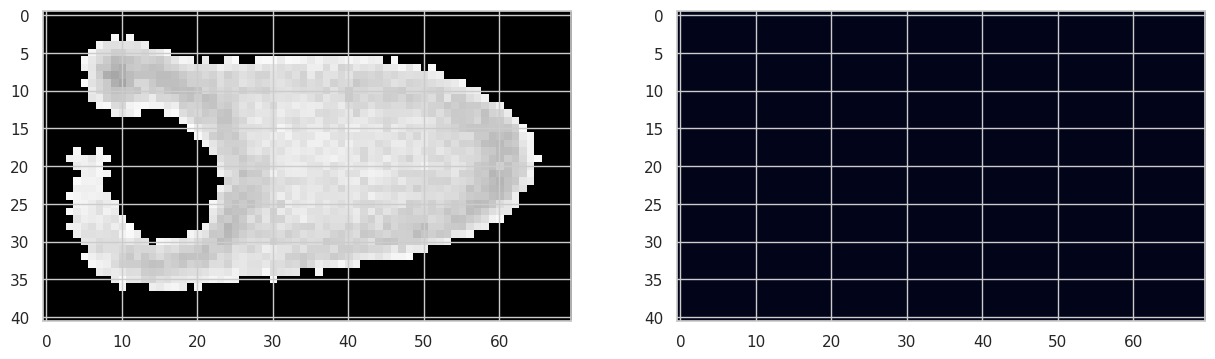

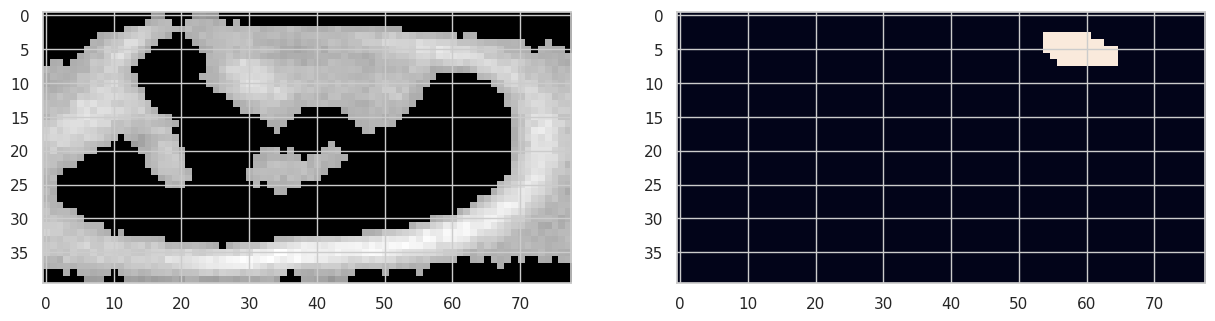

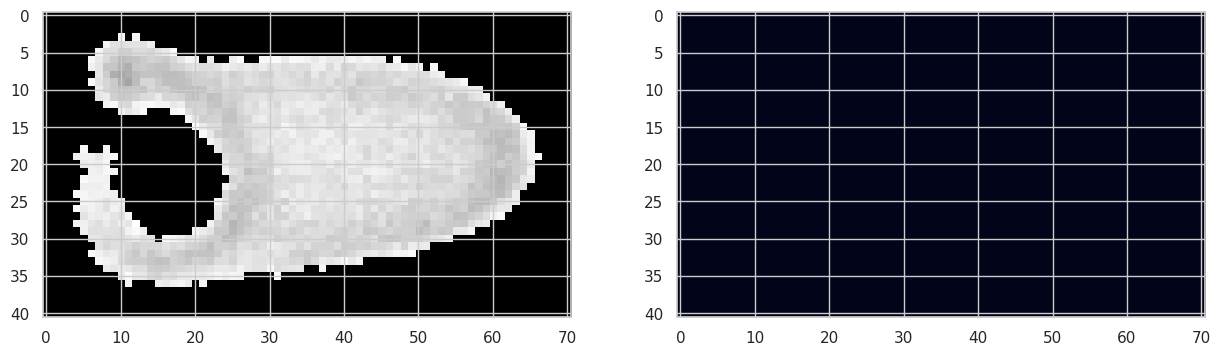

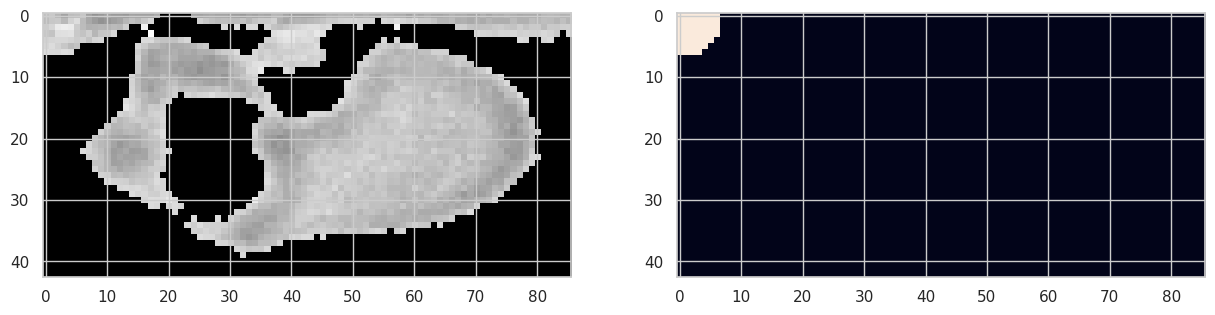

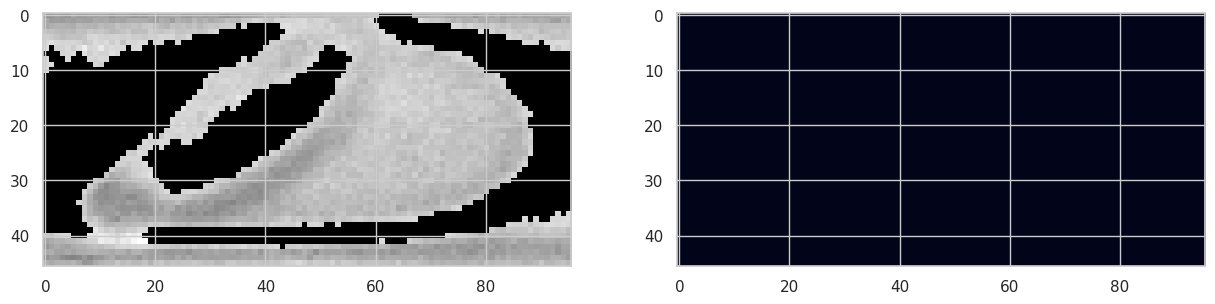

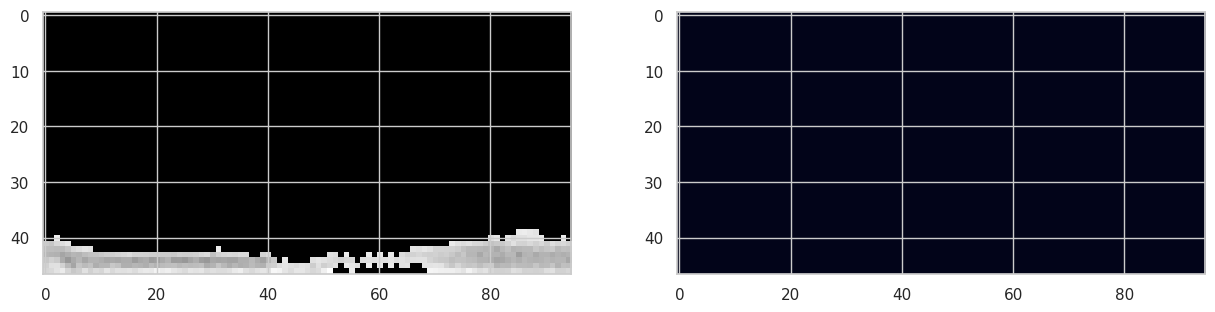

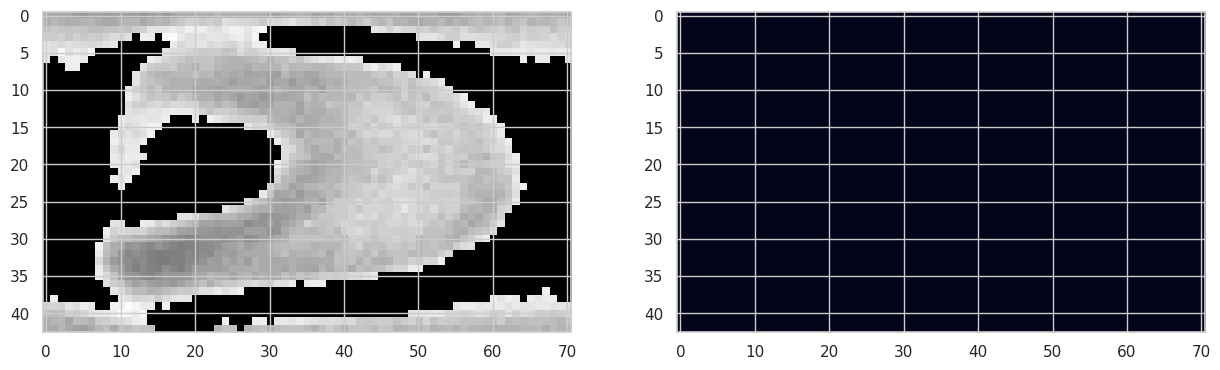

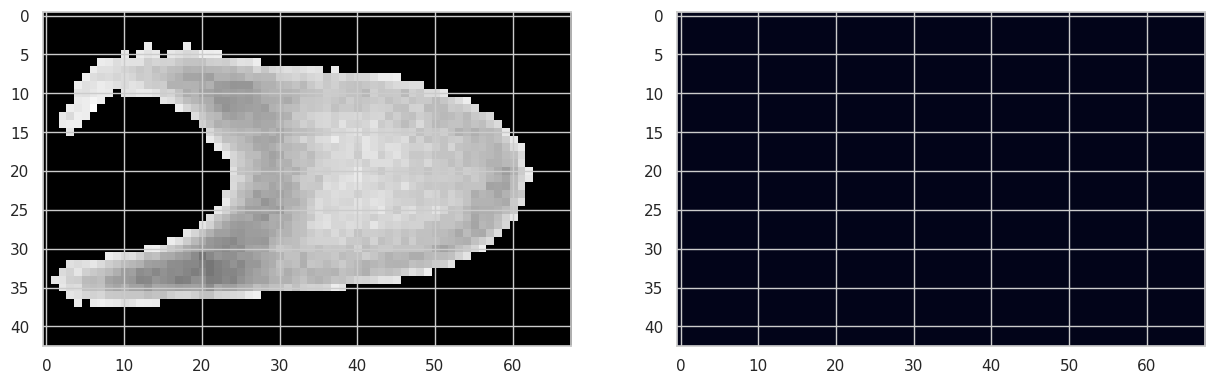

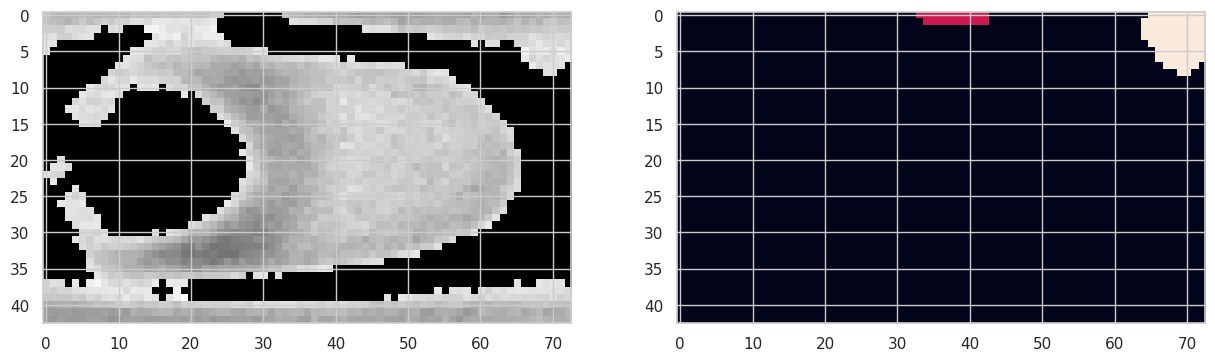

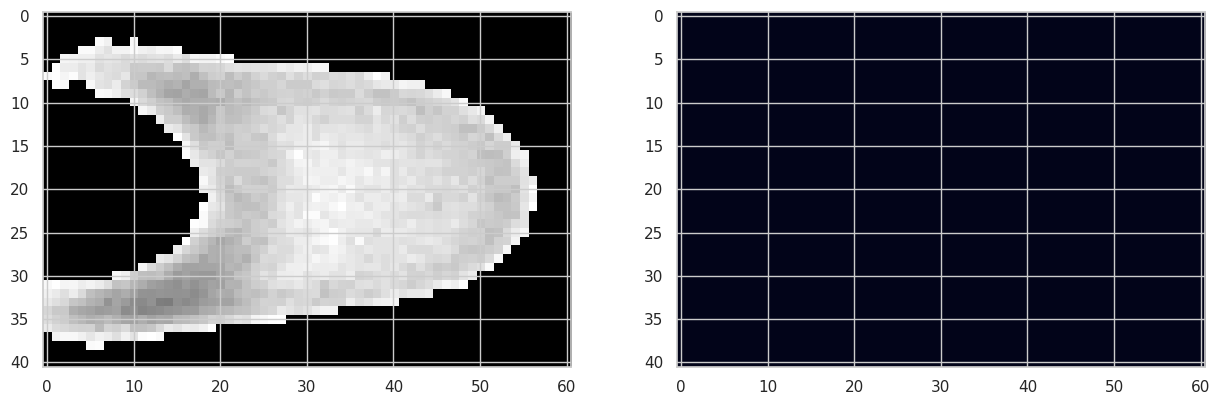

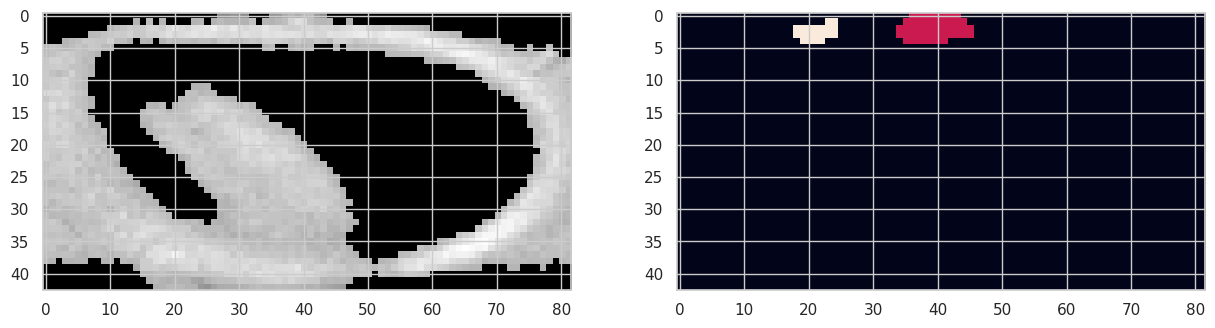

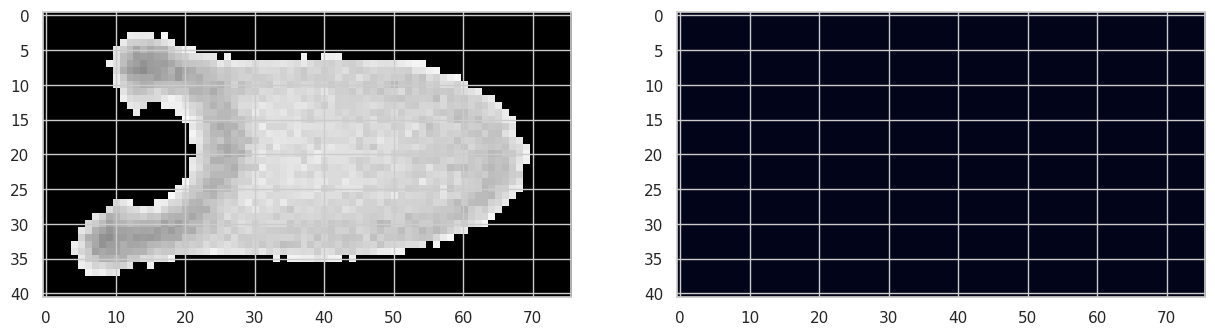

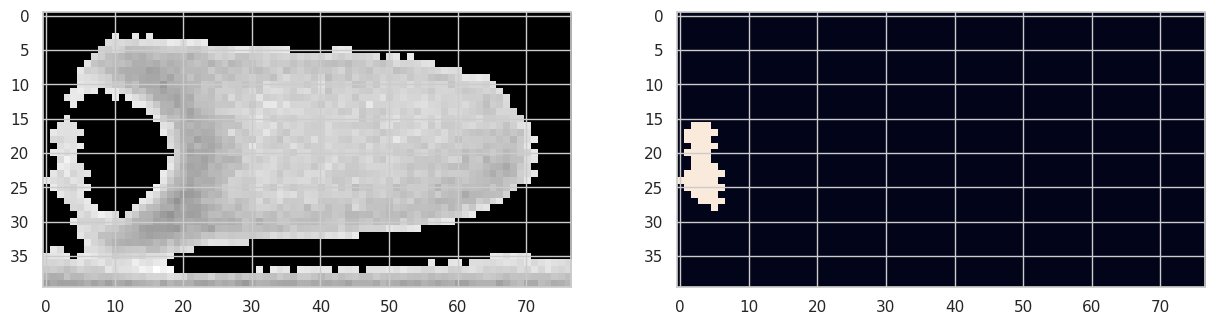

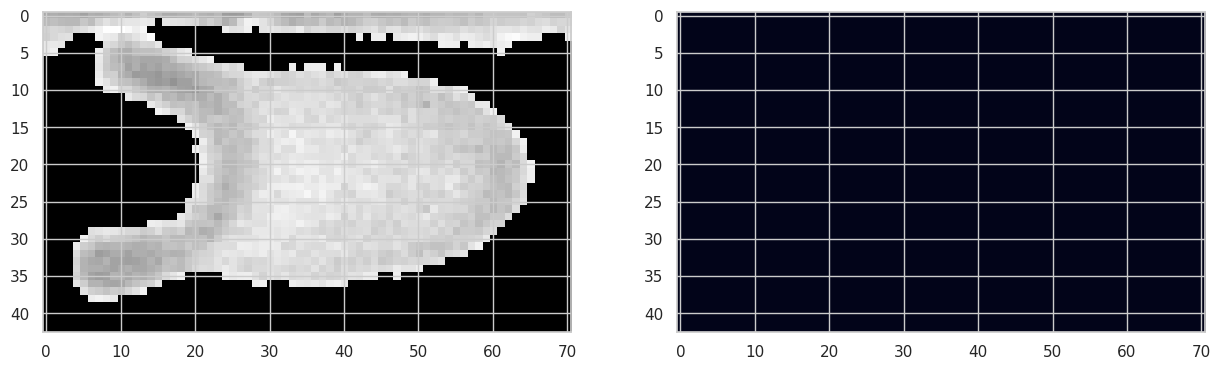

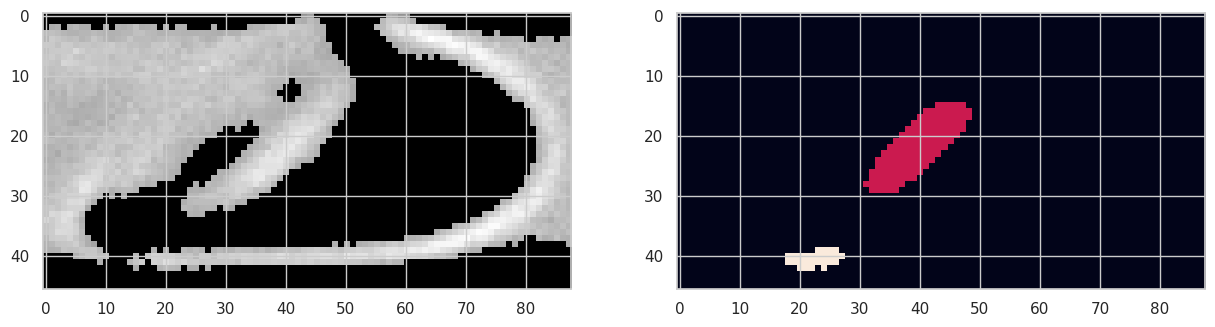

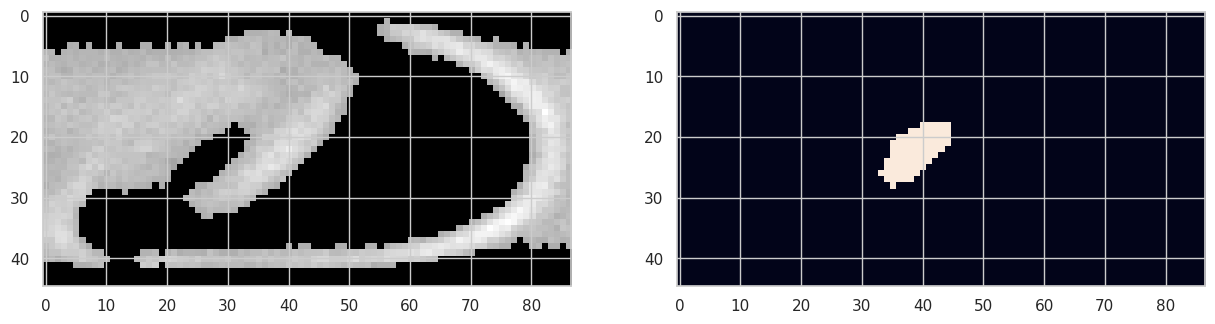

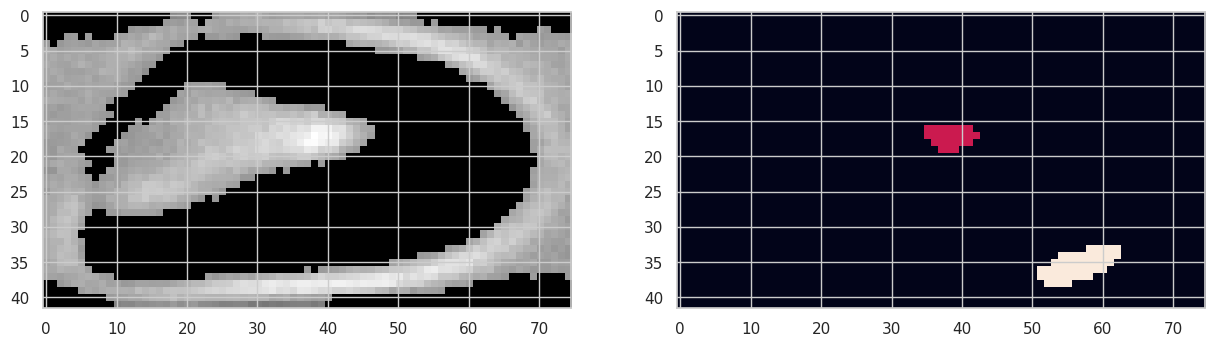

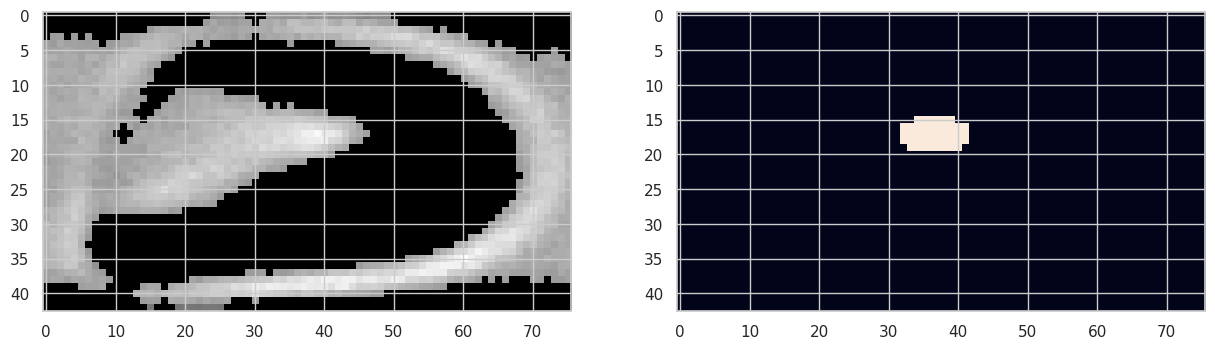

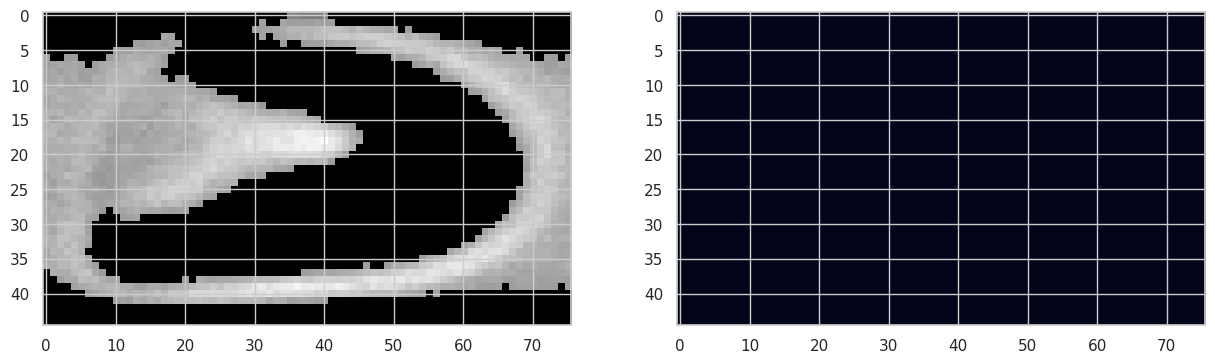

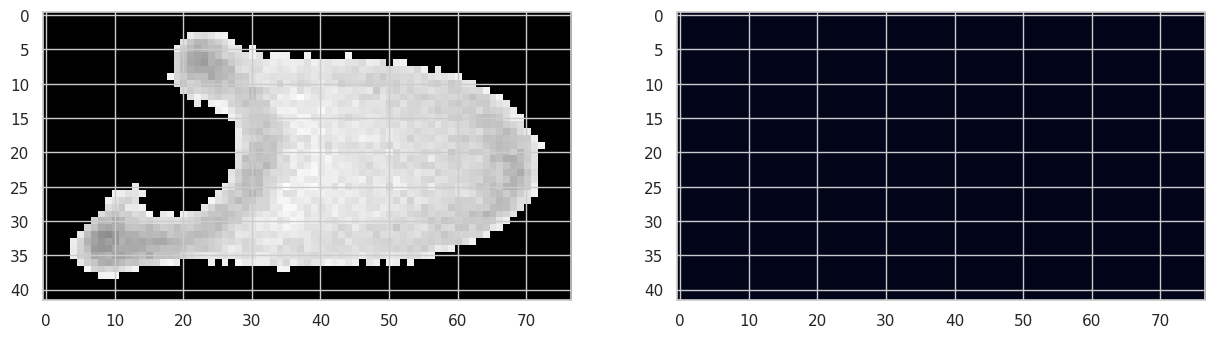

In [201]:
for i, m in zip(images, masks):
    plt.figure(figsize=(15, 20))
    plt.subplot(121)
    plt.imshow(i, cmap='gray')
    plt.subplot(122)
    plt.imshow(m)
    plt.show()

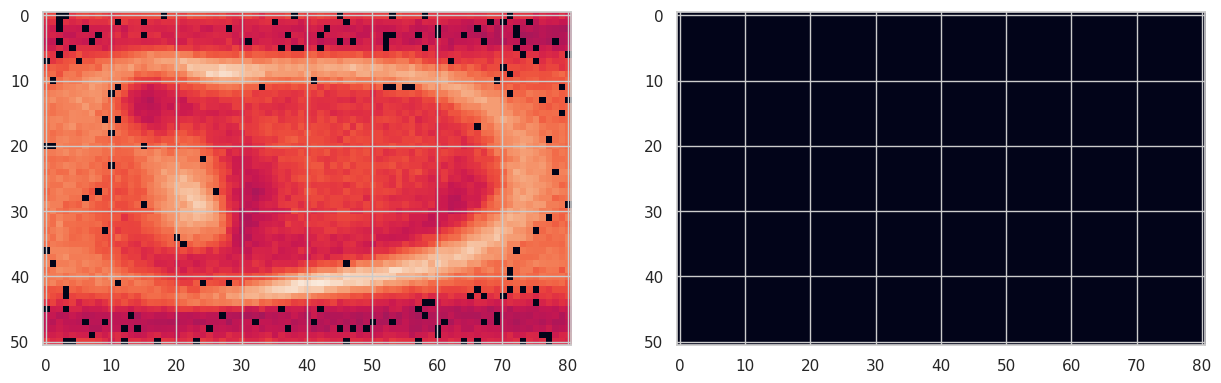

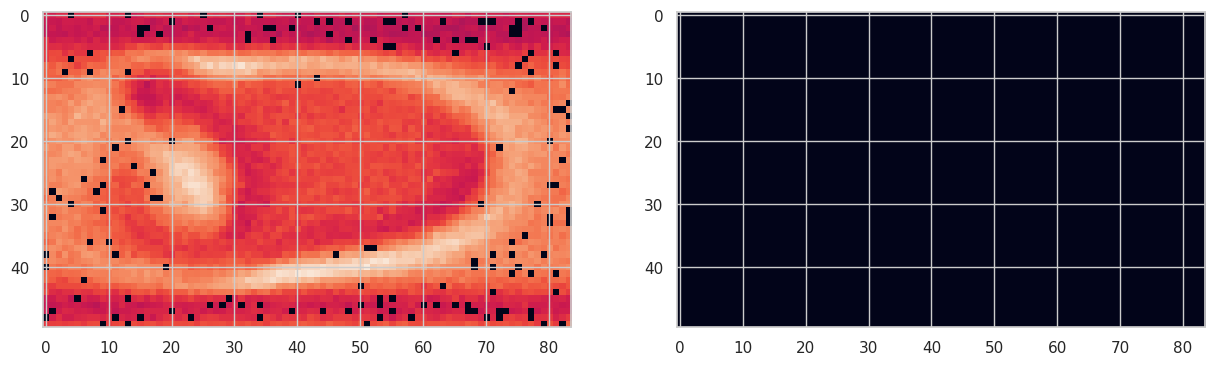

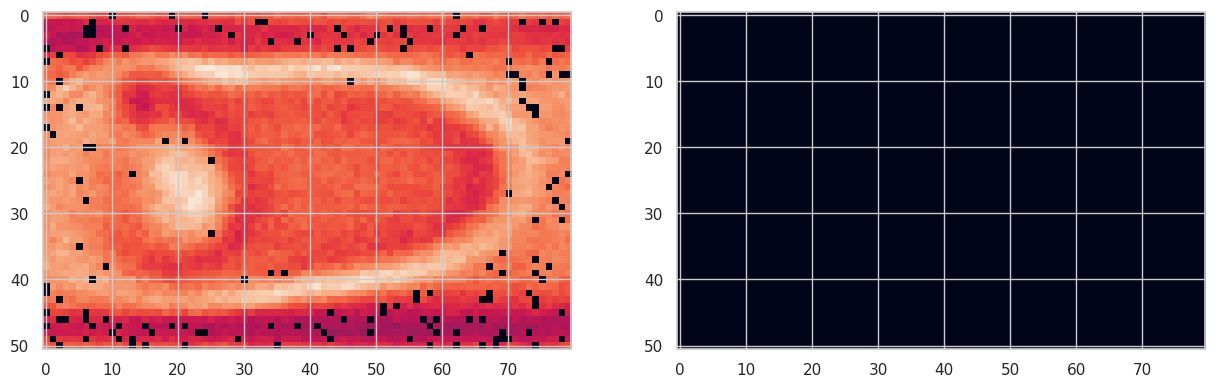

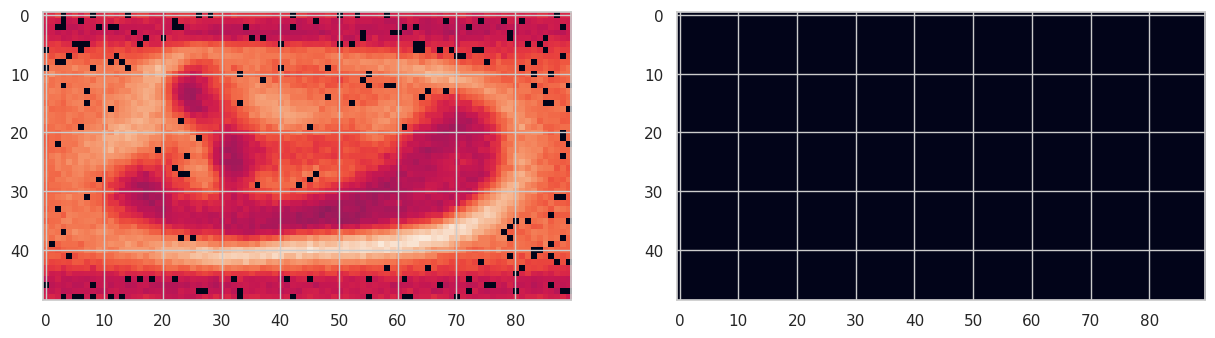

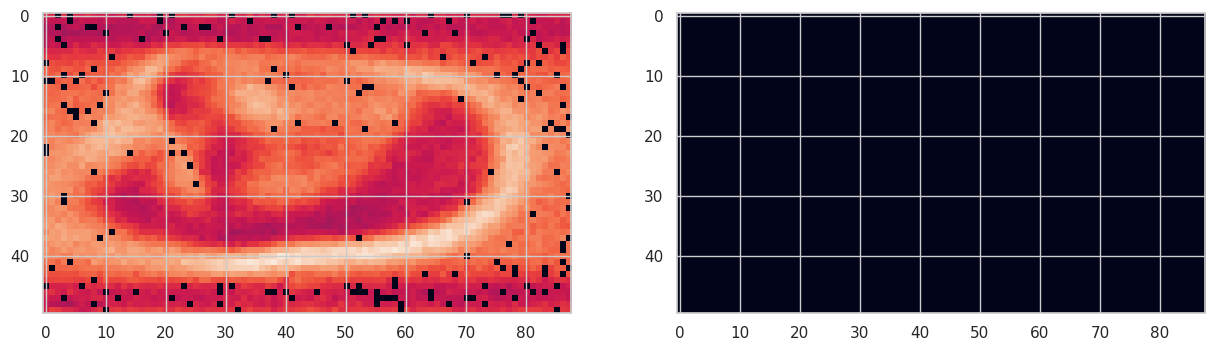

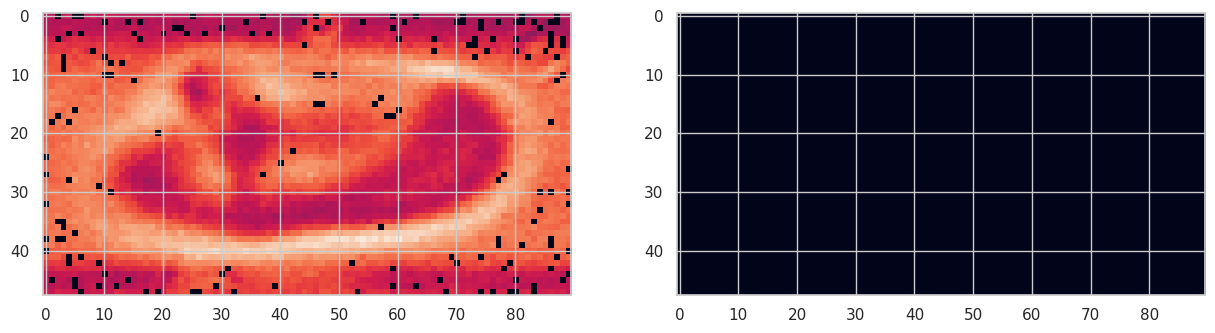

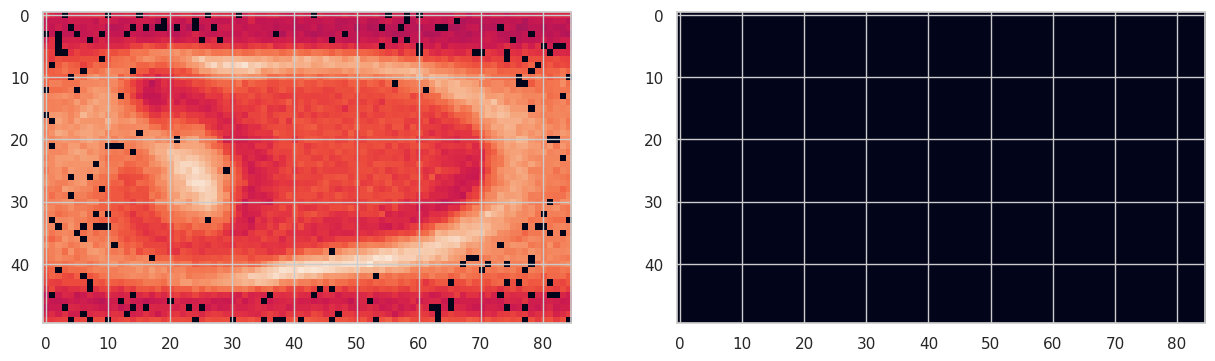

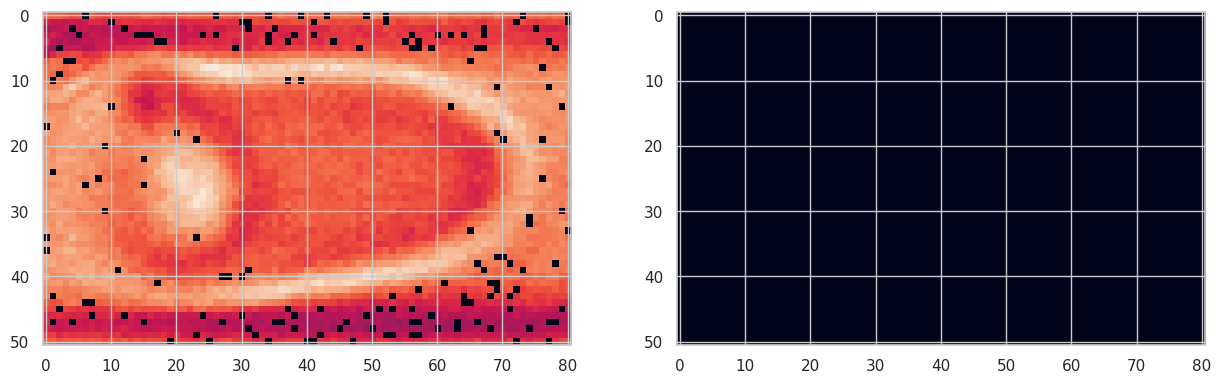

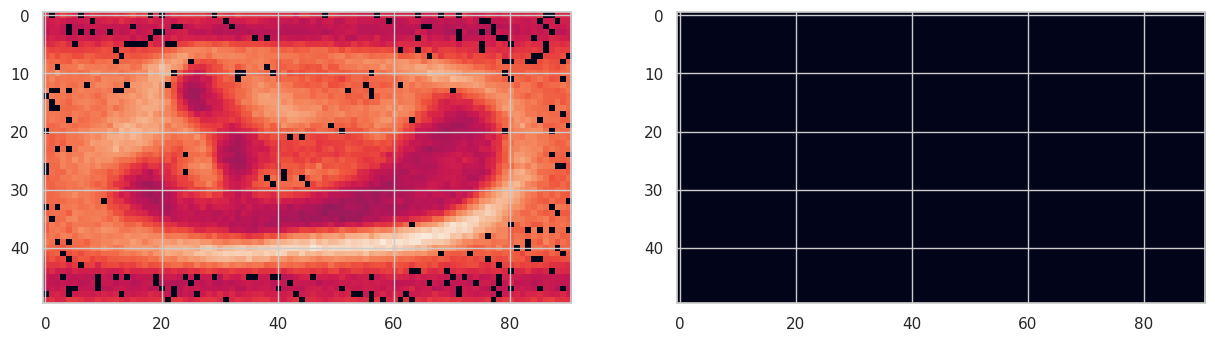

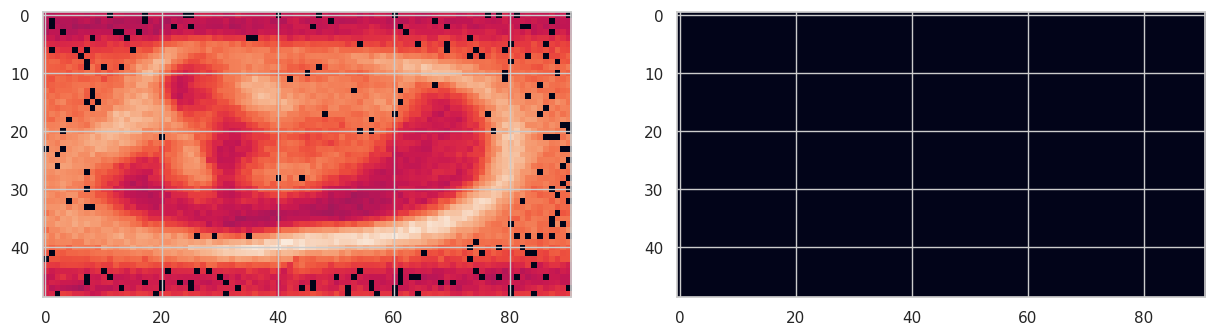

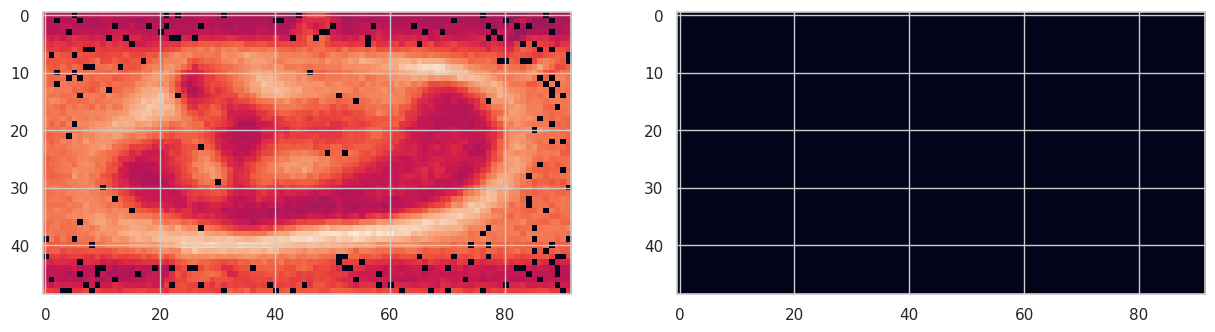

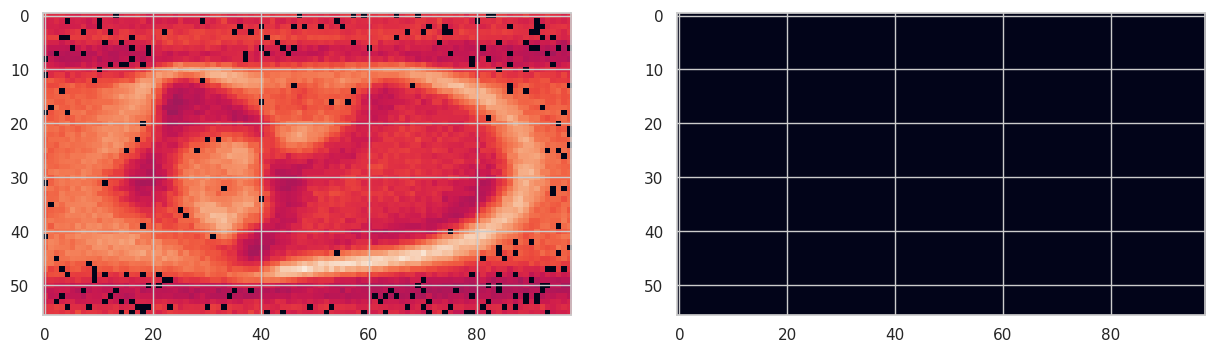

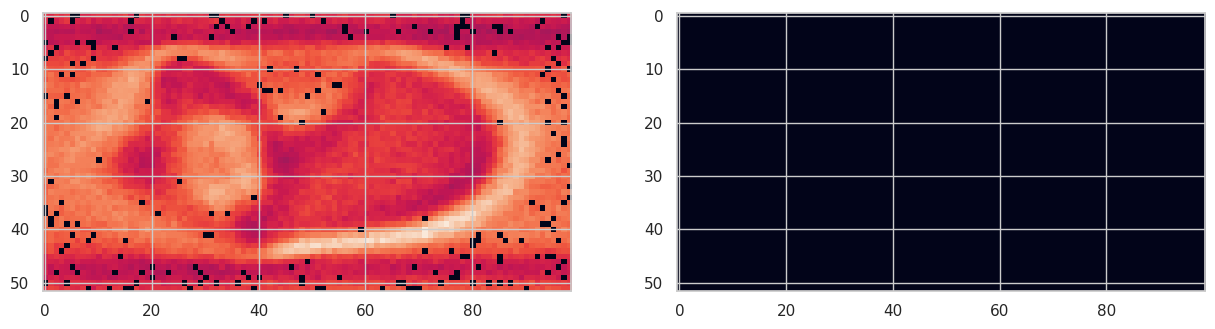

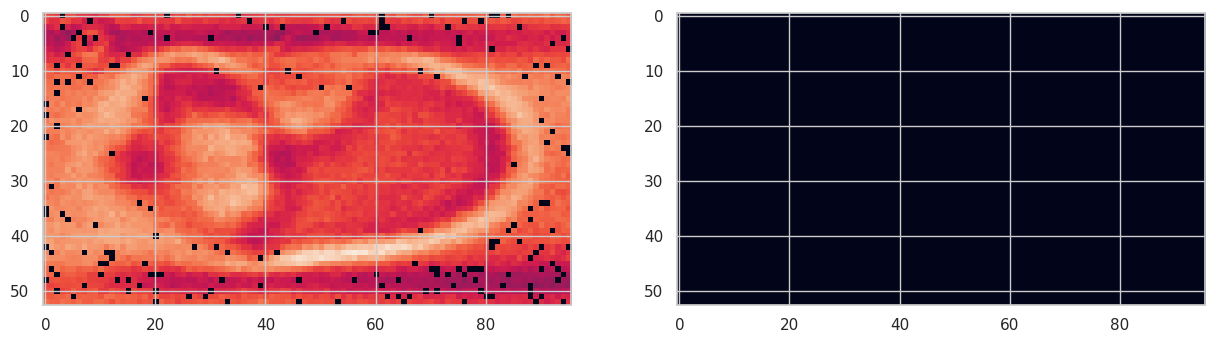

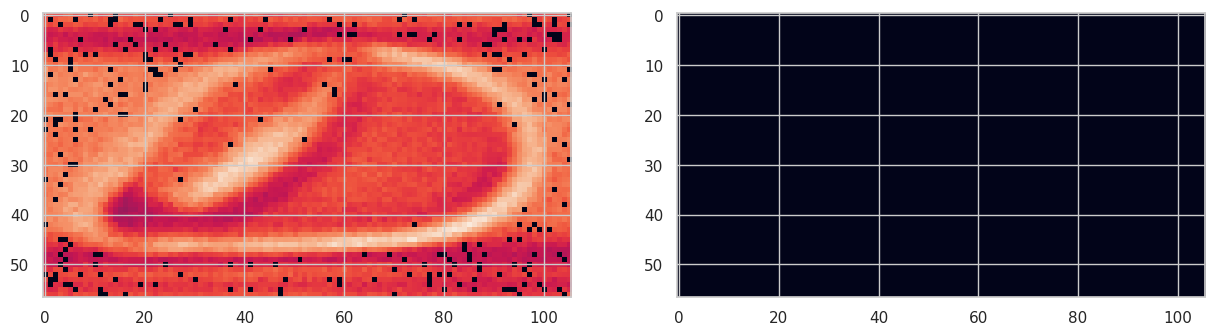

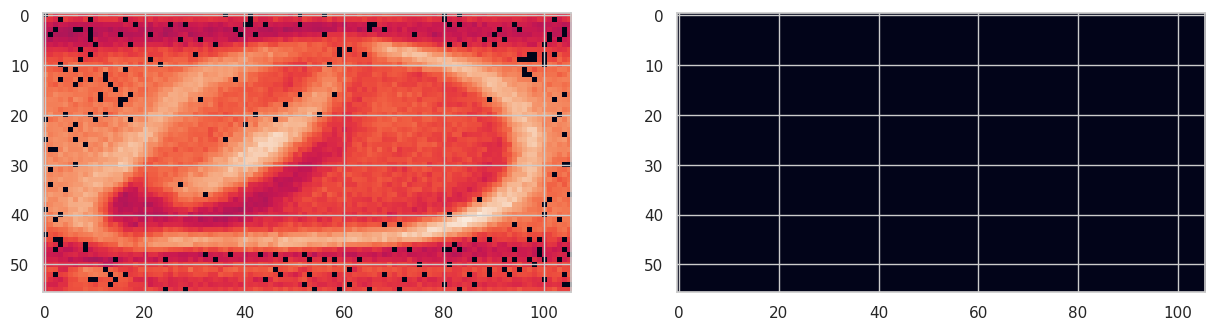

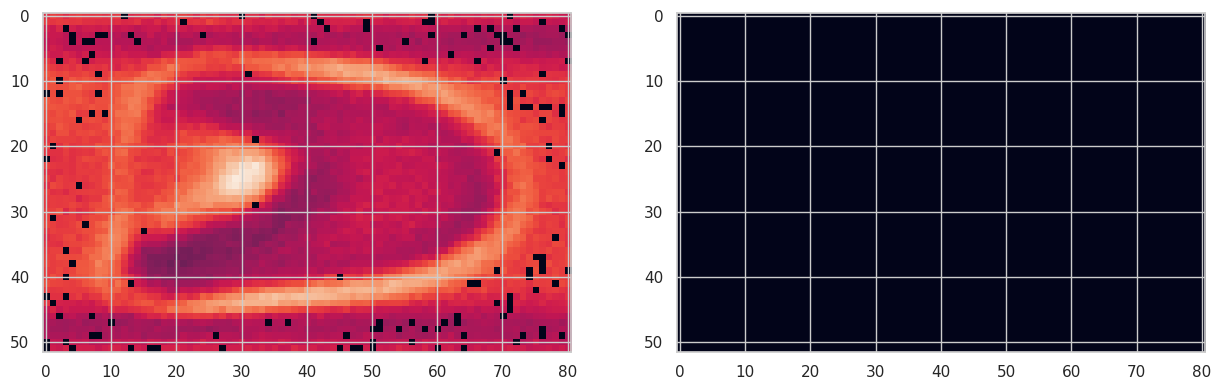

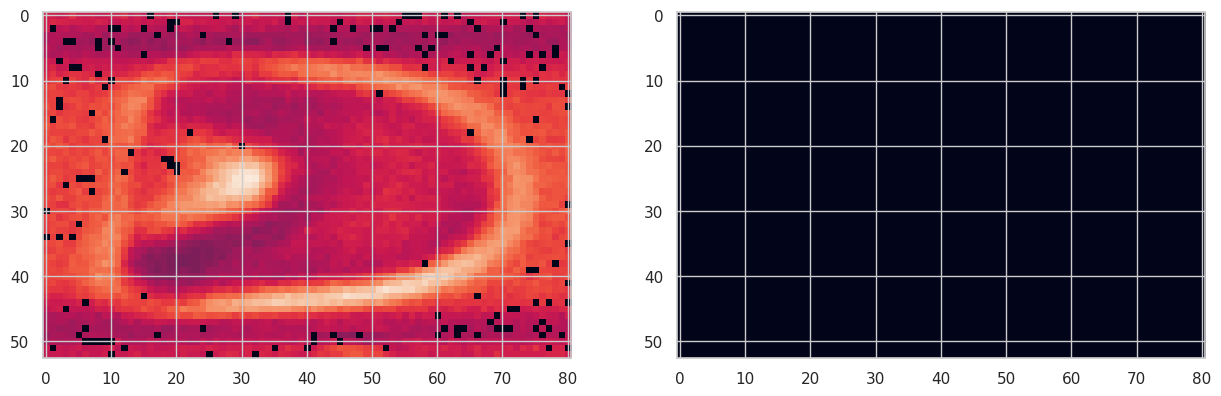

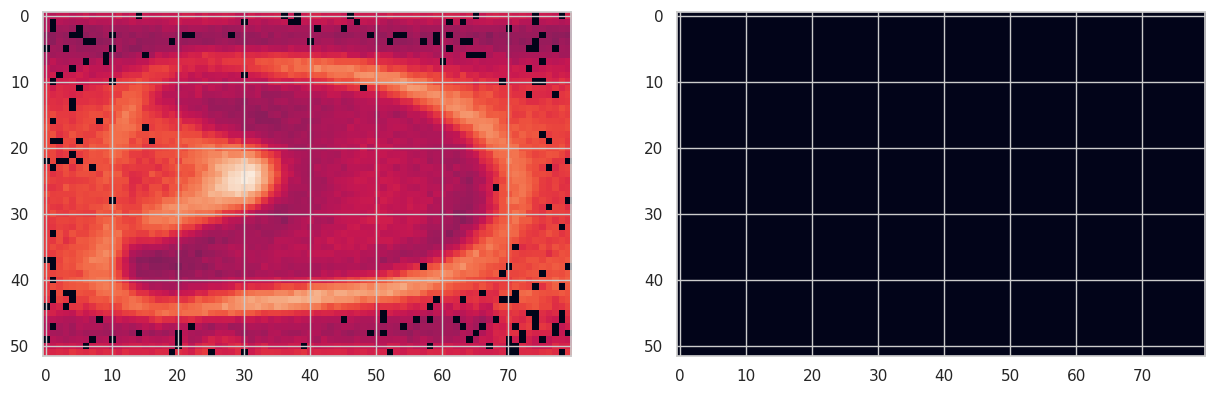

1


In [129]:
# Only keep images where exactly ONE cell was found (Avoid aggregate)
valid_images = []
valid_filenames = []
valid_masks =  []
idx = 0
for f, i, m in zip(filenames, images, masks):
    if len(np.unique(m)) == 2:
        valid_images.append(i)
        valid_filenames.append(f)
        valid_masks.append(m)
    elif idx < 20:
        plt.figure(figsize=(15, 20))
        plt.subplot(121)
        plt.imshow(i, cmap='gray')
        plt.subplot(122)
        plt.imshow(m)
        plt.show()
        idx += 1
            
print(len(valid_images))